# Demo - Amazon Rekognition, Amazon Textract e Amazon Comprehend

Vamos utilizar algumas das APIs de alguns serviços de inteligência artificial para extair informações de imagens e textos

In [1]:
import boto3 # aws python sdk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import IPython.display as disp
from IPython.display import Markdown

In [67]:
image_dir = '../sample-data/gov/images/'
text_dir = '../sample-data/gov/text/'

## Funções auxiliares

In [3]:
def load_image(filename):
    with open(filename, "rb") as imageFile:
      f = imageFile.read()
      return bytearray(f)

In [4]:
def convert_to_dataframe(labels):
    data = {'Label':[], 'Confidence':[]}
    for label in labels:
        data['Label'].append(label['Name'])
        data['Confidence'].append(label['Confidence'])
    return pd.DataFrame(data)[['Label', 'Confidence']]

In [5]:
def create_bounding_box(bbox, size):
    if len(bbox) != 4:
        return None
    return [ 
        bbox['Left']*size[0], bbox['Top']*size[1],
        (bbox['Left']*size[0])+bbox['Width']*size[0], 
        (bbox['Top']*size[1])+bbox['Height']*size[1]
    ]

In [123]:
def draw_bounding_box(filename, bbox, color, size):
    img = Image.open(filename)
    draw = ImageDraw.Draw(img)
    draw.line([(bbox[0], bbox[1]), (bbox[2], bbox[1])], fill=color, width=4)
    draw.line([(bbox[2], bbox[1]), (bbox[2], bbox[3])], fill=color, width=4)
    draw.line([(bbox[2], bbox[3]), (bbox[0], bbox[3])], fill=color, width=4)
    draw.line([(bbox[0], bbox[1]), (bbox[0], bbox[3])], fill=color, width=4)
    del draw
    plt.figure(figsize = (20,size))
    plt.imshow(img)

In [86]:
def print_lines_confidence(lines, lenght):
    try:
        for l in range(1, lenght):
            print(lines[l]['Text'] + '({})'.format(lines[l]['Confidence']))
    except Exception as e:
        print("Too long")

In [45]:
def delete_collection(name):
    try:
        response = rekognition.delete_collection(
            CollectionId=name
        )
    except Exception as e:
        print("Collection not found")

In [146]:
def delete_classifier():
    pass

In [145]:
def delete_entity():
    pass

## Amazon Rekognition

O Amazon Rekognition facilita a adição de análises de imagens e vídeos aos seus aplicativos. Basta fornecer uma imagem ou um vídeo à API do Amazon Rekognition, e o serviço poderá identificar objetos, pessoas, texto, cenas e atividades. 

Documentação: https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/rekognition.html

_fontes das imagens utilizadas:_ 
* http://agenciabrasil.ebc.com.br/
* http://g1.globo.com/
* https://www.jornalterceiravia.com.br/

In [7]:
# api client
rekognition = boto3.client('rekognition')

### Detecção de texto

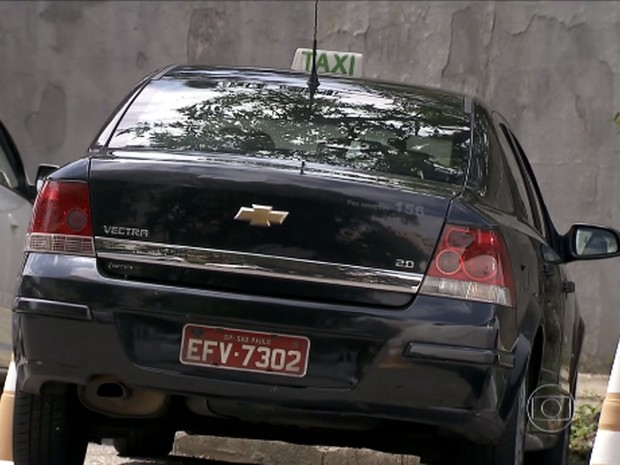

In [8]:
disp.Image(image_dir + 'carro.jpg', width=400)

In [9]:
response = rekognition.detect_text(
    Image={'Bytes': load_image(image_dir + 'carro.jpg')}
)

for i in response['TextDetections']:
    if i['Confidence'] >= 95:
        print( '%s - Confidence[%f]' % (i['DetectedText'], i['Confidence']) )

EFV-7302 - Confidence[98.159729]
EFV-7302 - Confidence[98.159729]


### Detecção de objetos

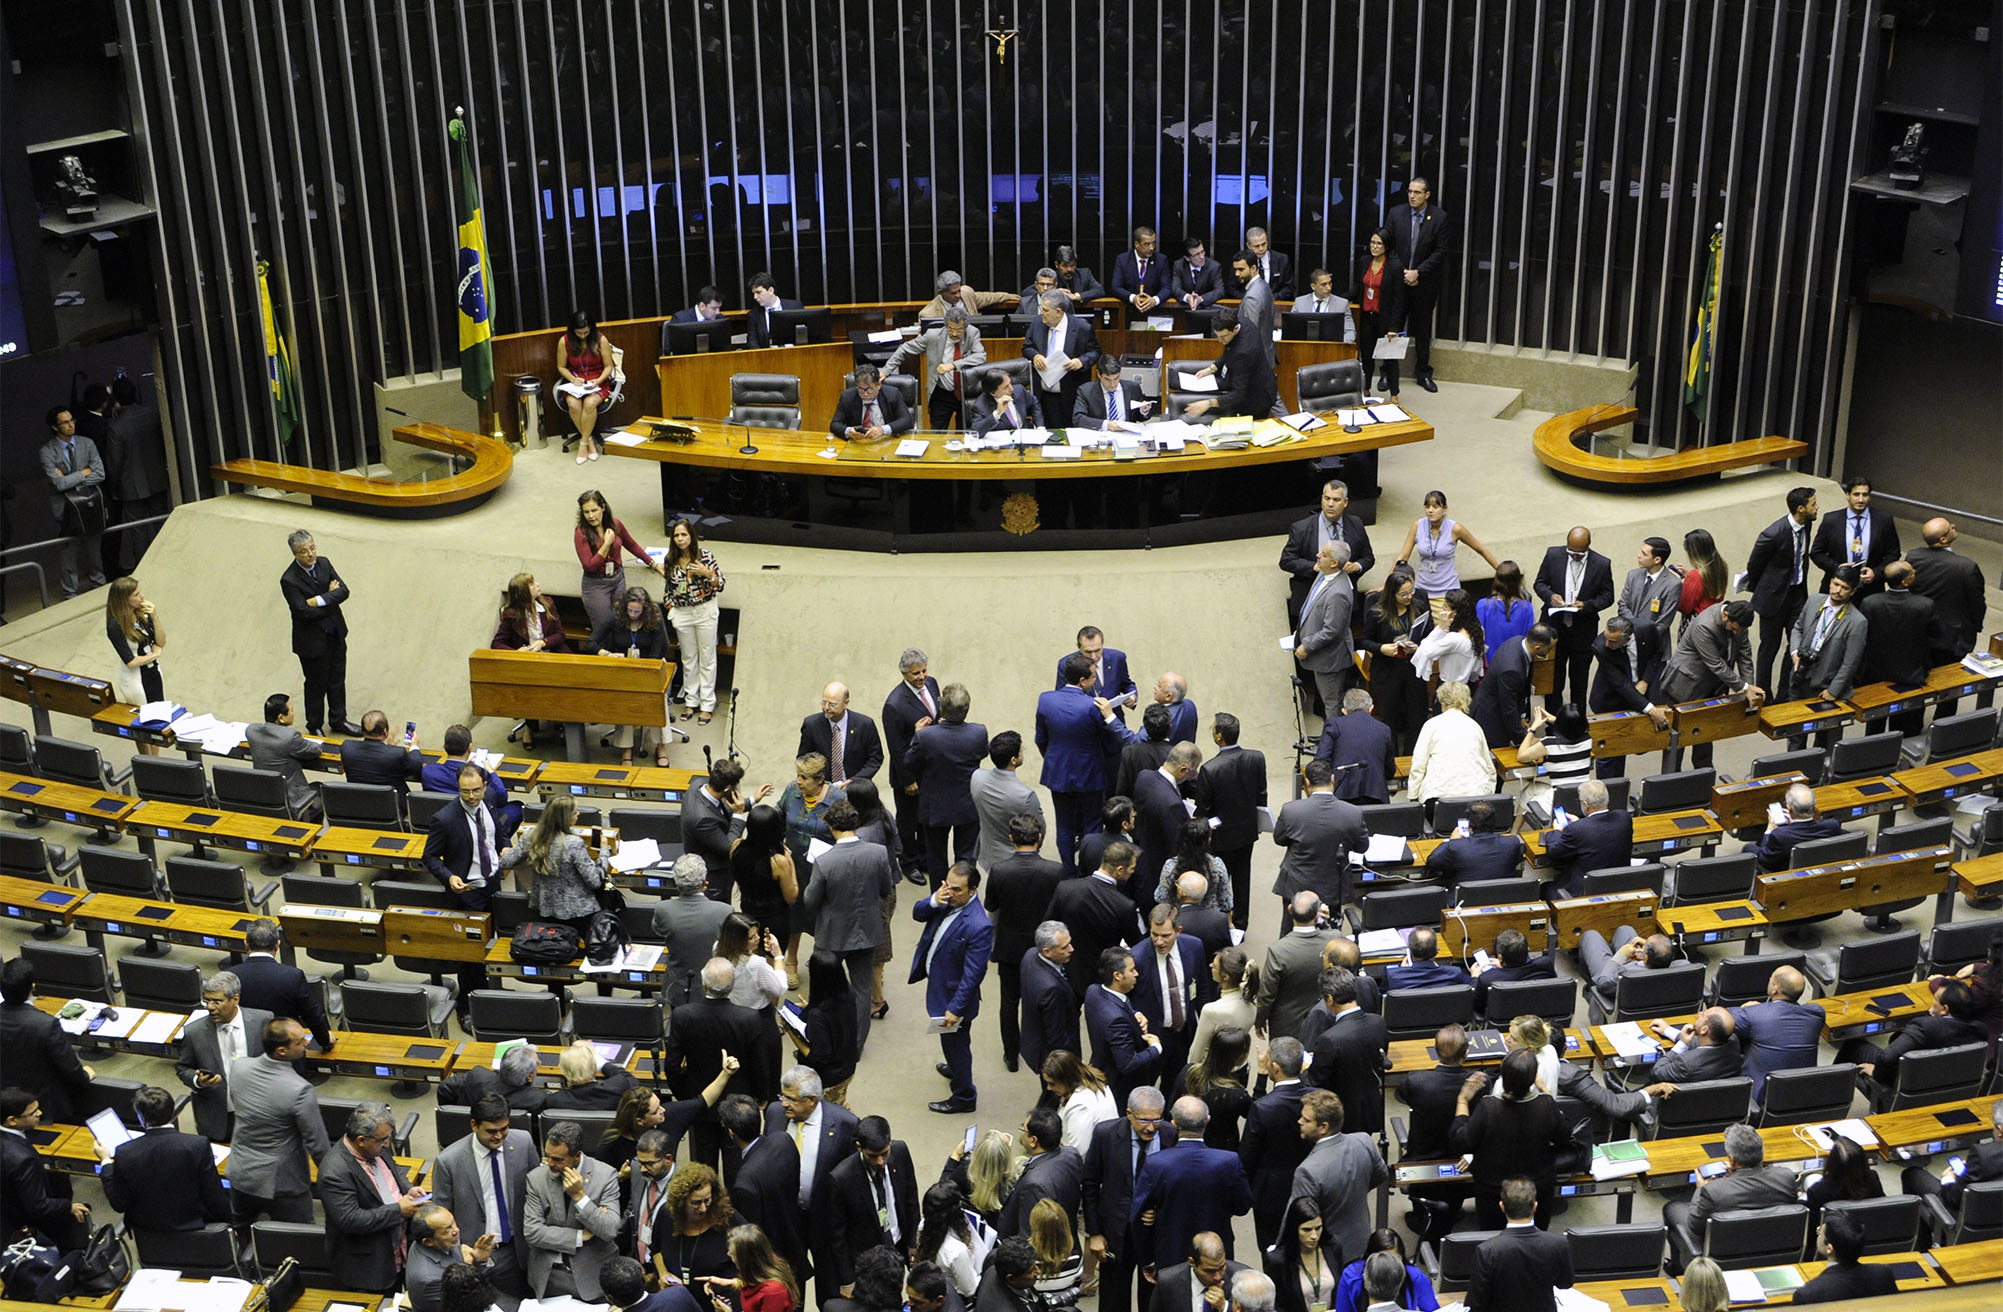

In [10]:
disp.Image(image_dir + 'agenciabrasil-4.jpg', width=400)

In [11]:
response = rekognition.detect_labels(
    Image={'Bytes': load_image(image_dir + 'agenciabrasil-4.jpg')},
    MaxLabels=5,
    MinConfidence=70
)

convert_to_dataframe(response['Labels'])

,Label,Confidence
0,Person,98.934669
1,Human,98.934669
2,Crowd,87.282181


### Moderação

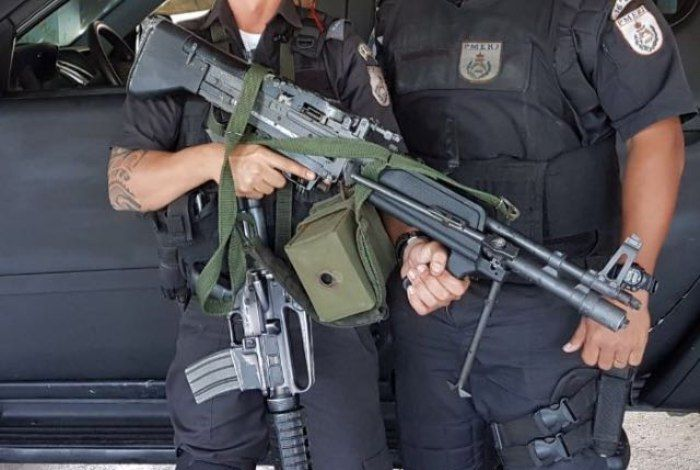

In [12]:
disp.Image(image_dir + 'arma.jpg', width=300)

In [13]:
response = rekognition.detect_moderation_labels(
    Image={'Bytes': load_image(image_dir + 'arma.jpg')},
    MinConfidence=70
)

convert_to_dataframe(response['ModerationLabels'])

,Label,Confidence
0,Weapon Violence,97.422646
1,Violence,97.422646


### Reconhecimento de pessoas públicas

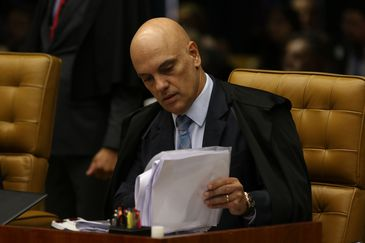

In [14]:
disp.Image(image_dir + 'agenciabrasil-2.jpg', width=300)

Alexandre de Moraes 99.98983001708984


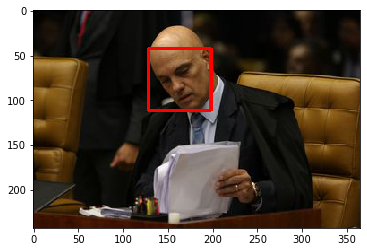

In [124]:
response = rekognition.recognize_celebrities(
    Image={'Bytes': load_image(image_dir + 'agenciabrasil-2.jpg')}
)

img = Image.open(image_dir + 'agenciabrasil-2.jpg')
bbox = create_bounding_box(response['CelebrityFaces'][0]['Face']['BoundingBox'], img.size )
confidence = response['CelebrityFaces'][0]['Face']['Confidence']
name = response['CelebrityFaces'][0]['Name']

print(name, confidence)
draw_bounding_box(image_dir + 'agenciabrasil-2.jpg', bbox, 'red', 4)

### Análise facial

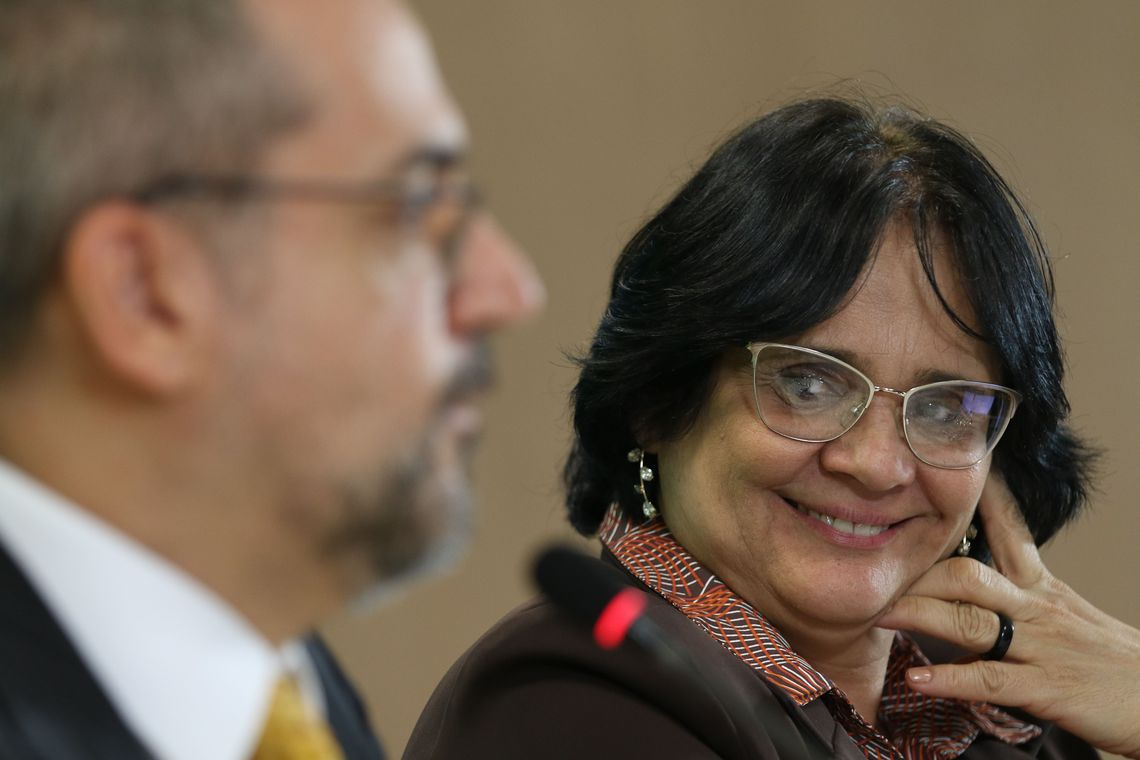

In [16]:
disp.Image(image_dir + 'agenciabrasil-5.jpg', width=400)

In [17]:
response = rekognition.detect_faces(
    Image={'Bytes': load_image(image_dir + 'agenciabrasil-5.jpg')},
    Attributes=['ALL']
)

age = response['FaceDetails'][0]['AgeRange']['High']
gender = response['FaceDetails'][0]['Gender']['Value']

print(age, gender)

age = response['FaceDetails'][1]['AgeRange']['High']
gender = response['FaceDetails'][1]['Gender']['Value']

print(age, gender)

34 Male
57 Female


### Comparação facial

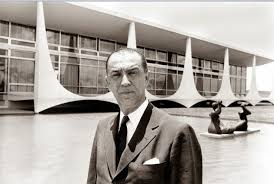

In [18]:
disp.Image(image_dir + 'jk-1.jpg', width=300)

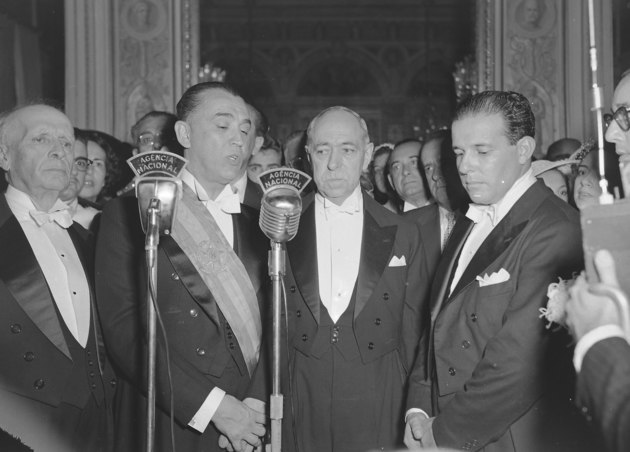

In [19]:
disp.Image(image_dir + 'jk-2.jpg', width=300)

In [112]:
response = rekognition.compare_faces(
    SourceImage={'Bytes': load_image(image_dir + 'jk-1.jpg')},
    TargetImage={'Bytes': load_image(image_dir + 'jk-2.jpg')}
)

imgA = Image.open(image_dir + 'jk-1.jpg')
imgB = Image.open(image_dir + 'jk-2.jpg')

similarity = response['FaceMatches'][0]['Similarity']
bboxA = create_bounding_box( response['SourceImageFace']['BoundingBox'], imgA.size )
bboxB = create_bounding_box( response['FaceMatches'][0]['Face']['BoundingBox'], imgB.size )

Similarity: 95.69002532958984


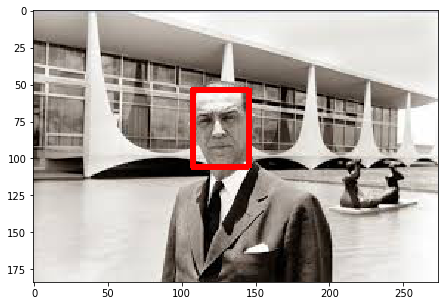

In [125]:
print( 'Similarity: {}'.format( similarity ) )
if bboxA: draw_bounding_box(image_dir + 'jk-1.jpg', bboxA, 'red', 5)

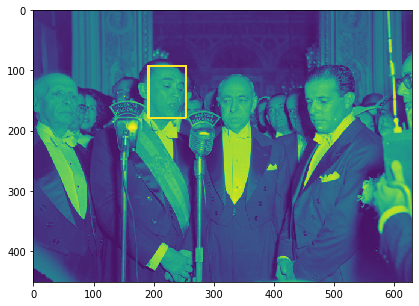

In [126]:
if bboxB: draw_bounding_box(image_dir + 'jk-2.jpg', bboxB, 'white', 5)

### Busca por faces

O Rekognition possui uma feature para que possamos criar coleções de faces, efetuando uma busca otimizada ao receber uma nova face

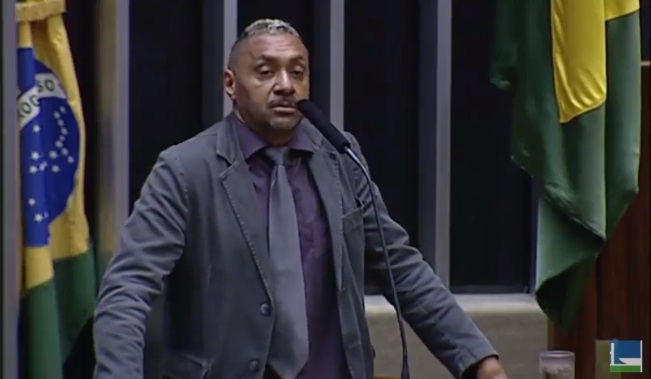

In [127]:
disp.Image(image_dir + 'tiririca-1.jpg', width='400')

In [116]:
try:
    delete_collection("Deputados")
    response = rekognition.create_collection(
        CollectionId='Deputados'
    )
    faces = {
        'Tiririca': image_dir + 'tiririca-1.jpg'
    }
    for ext_id, image_name in faces.items():
        response = rekognition.index_faces(
            CollectionId='Deputados',
            Image={'Bytes': load_image(image_name)},
            ExternalImageId=ext_id,
        )
        if len(response['FaceRecords']) > 0:
            for i in response['FaceRecords']:
                print( ext_id, i['Face']['FaceId'])
except Exception as e:
    print(e)

Tiririca ac33abf4-b7af-45e1-b48f-ffeccc0320f9


Agora iremos enviar uma imagem diferente da utilizada na coleção e buscar por faces conhecidas pela coleção

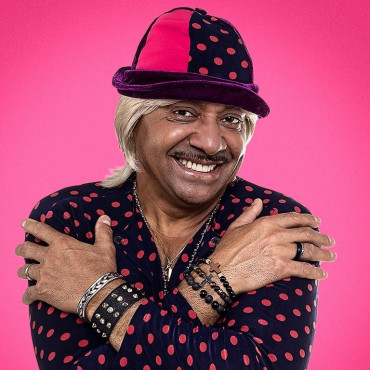

In [117]:
disp.Image(image_dir + 'tiririca-2.jpg', width='400')

In [118]:
faces = rekognition.search_faces_by_image(
    CollectionId='Deputados',
    Image={ 'Bytes': load_image( image_dir + 'tiririca-2.jpg') },
    MaxFaces=10
)['FaceMatches']

print('# Mached faces in the collection: {}'.format( len(faces)))
print('FaceId: {} - Similarity: {}'.format(faces[0]['Face']['ExternalImageId'], faces[0]['Similarity']))

# Mached faces in the collection: 1
FaceId: Tiririca - Similarity: 94.29463958740234


## Amazon Textract

O Amazon Textract é um serviço que extrai automaticamente texto e dados de documentos digitalizados. O Amazon Textract vai além do simples OCR (Reconhecimento óptico de caracteres) para também identificar o conteúdo de campos em formulários e informações armazenadas em tabelas.

Documentação: https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/textract.html

In [119]:
# api client
textract = boto3.client('textract')

### OCR

Síncrono com suporte a documentos JPEG e PNG. Assíncrono com suporte a dcoumentos JPEG, PNG e PDF. Neste exemplo estamos utilizando o método síncrono.

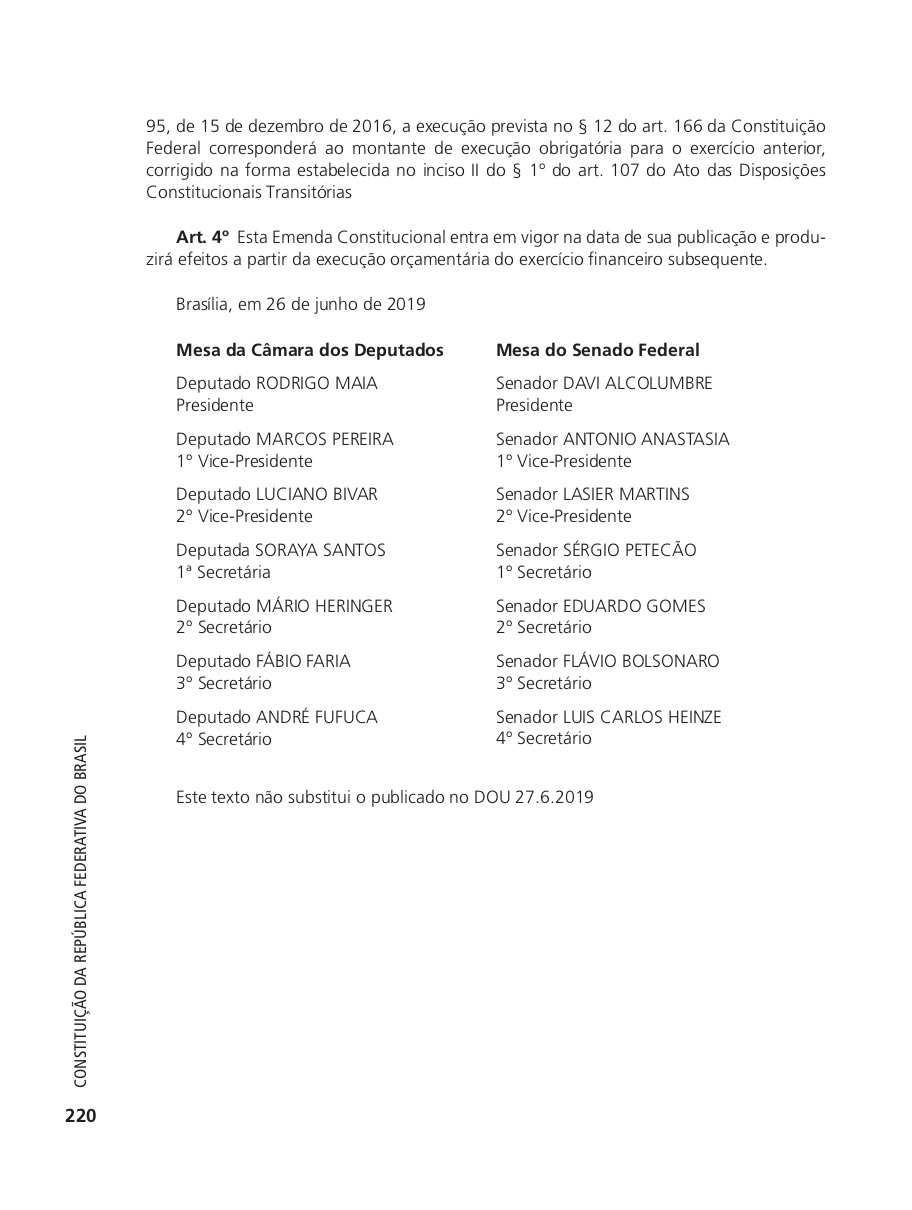

In [120]:
disp.Image(text_dir + 'constituicao-pg220.jpg', width=600)

In [136]:
response = textract.detect_document_text(
    Document={
        'Bytes': load_image(text_dir + 'constituicao-pg220.jpg')
    }
)

text = response['Blocks'][1]['Text'] # storing text to use with Comprehend

print_lines_confidence(response['Blocks'], 5)

95, de 15 de dezembro de 2016, a execucao prevista no S 12 do art. 166 da Constituicao(96.1034927368164)
Federal correspondera ao montante de execucao obrigatoria para O exercicio anterior,(94.62025451660156)
corrigido na forma estabelecida no inciso II do S 19 do art. 107 do Ato das Disposicoes(96.04552459716797)
Constitucionais Transitorias(97.90821838378906)


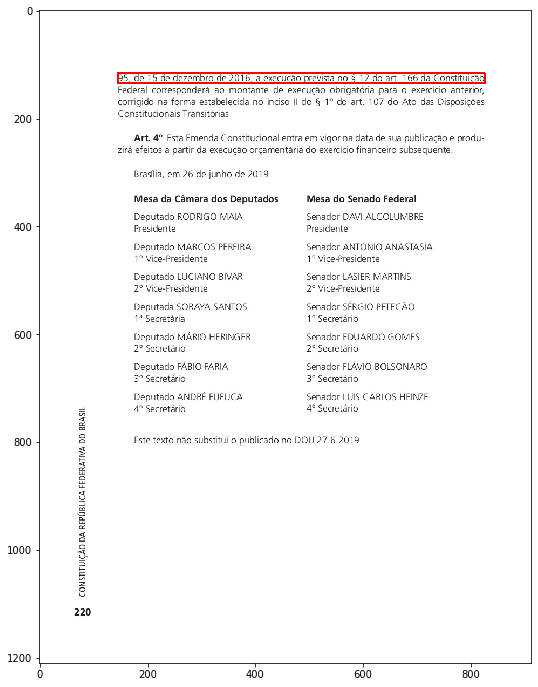

In [132]:
# bbox on the first line
img = Image.open(text_dir + 'constituicao-pg220.jpg')
bbox = create_bounding_box( response['Blocks'][1]['Geometry']['BoundingBox'], img.size )
draw_bounding_box(text_dir + 'constituicao-pg220.jpg', bbox, 'red', 12)

## Amazon Comprehend

O Amazon Comprehend é um serviço de Natural Language Processing (NLP – Processamento de linguagem natural) que usa Machine Learning para encontrar insights e relações dentro de documentos em texto. Nenhuma experiência de Machine Learning necessária.

Documentação: https://boto3.amazonaws.com/v1/documentation/api/latest/reference/services/comprehend.html

In [64]:
# api client
comprehend = boto3.client('comprehend')

### Análise de texto

Também é possível trabalhar de forma síncrona e assíncrona para análise de texto. Neste exemplo estamos utilizando o método síncrono.

In [150]:
print(text)

response = comprehend.detect_dominant_language(Text = text)

print(response['Languages'][0]['LanguageCode'] + ' - Confidence: {}'.format(response['Languages'][0]['Score']))

response = comprehend.detect_entities(
    Text = text,
    LanguageCode = 'pt'
)

print(response)

response = comprehend.detect_key_phrases(
    Text = text,
    LanguageCode = 'pt'
)

print(response)

response = comprehend.detect_sentiment(
    Text = text,
    LanguageCode = 'pt'
)

print(response)

response = comprehend.detect_syntax(
    Text = text,
    LanguageCode = 'pt'
)

print(response)

95, de 15 de dezembro de 2016, a execucao prevista no S 12 do art. 166 da Constituicao
pt - Confidence: 0.9900856018066406
{'Entities': [{'Score': 0.3996194303035736, 'Type': 'TITLE', 'Text': '95', 'BeginOffset': 0, 'EndOffset': 2}, {'Score': 0.9999998211860657, 'Type': 'DATE', 'Text': '15 de dezembro de 2016', 'BeginOffset': 7, 'EndOffset': 29}, {'Score': 0.9614915251731873, 'Type': 'TITLE', 'Text': 'S 12', 'BeginOffset': 54, 'EndOffset': 58}, {'Score': 0.988928496837616, 'Type': 'OTHER', 'Text': 'art. 166', 'BeginOffset': 62, 'EndOffset': 70}, {'Score': 0.7557771801948547, 'Type': 'TITLE', 'Text': 'Constituicao', 'BeginOffset': 74, 'EndOffset': 86}], 'ResponseMetadata': {'RequestId': '087ad521-ae50-4821-951e-b574e252fa72', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '087ad521-ae50-4821-951e-b574e252fa72', 'content-type': 'application/x-amz-json-1.1', 'content-length': '487', 'date': 'Fri, 22 Nov 2019 18:02:54 GMT'}, 'RetryAttempts': 0}}
{'KeyPhrases': [{'Score': 0.9065

### Classificador personalizado

### Entidades personalizadas

## Limpando os recursos utilizados

In [138]:
# Rekognition collection
delete_collection('Deputados')

# Classificador
delete_classifier()

# Entidades
delete_entity()